# Component separation validity check

This notebook presents a modification of a component separation algorithm based on the Wavelet Phase Harmonics (WPH) statistics. Usually, this algorithm is used to compute one possible result. The purpose is to explore the distribution of outcomes this modification of the algorithm can generate and to evaluate their qualities.

## 1. Component separation principle

The component separation principle is described by Constant Auclair in https://github.com/constantauclair/CompSep and based on works described in Régaldo-Saint Blancard et al. 2021, Delouis et al. 2022 and Auclair et al. 2023.

The general use of this technique is to remove or isolate a component of an image (instrumental noise, Cosmic Infrared Background, stars, ...) from observation, as long as the statistical behaviour of the component to isolate/remove is known.
We will focus here on the case of the removal of white noise from an image : $d = x + n$, where d is the data, x the signal of interest, and n the noise. Later, $d$ will be the running map so $x + n$ will be referred to as $d_{init}$.

The general context of this type of algorithm is a gradient descent in pixel space in order to satisfy a statistical constraint. We consider a map $d$ and a set of white noises $n_a$. The gradient descent target is to find a map $s$ satisfying the constraint $<\Phi(s + n_a)> = \Phi(d_{init})$, where $<>$ is an average on the set of noises and $\Phi$ is a vector of WPH statistics.

The purpose of this study is to modify the previous algorithm to allow one to get a distribution of outcomes $s$ rather than just one, and to evaluate to what extent this distribution is a good estimation of the clean map ($x$).

To do so, we will only work here with a simulated image of Magnetized Turbulence and artificially add noise to them, so we know what a perfect result could be.

## 2. Example of a component separation

We will first show how the initial component separation algorithm, as described by Constant Auclair, works. We will need a few libraries :

In [8]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch
import time
import scipy.optimize as opt

You can choose to calculate on the cpu or gpu by changing the following line :

In [9]:
#device = "cpu"
device = 0 # gpu

We load a test image for the example, normalized with mean = 0, std = 1 :

<IPython.core.display.Javascript object>


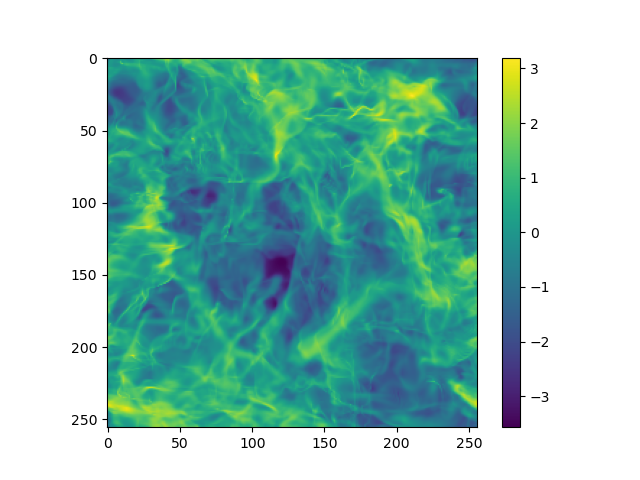

In [10]:
x = np.load("Exemple_data.npy")[5]
x = (x - x.mean())/x.std() # normalization of the image with mean = 0, std = 1
plt.figure()
plt.imshow(x)
plt.colorbar()

Then we can add white noise to this image, with a signal-to-noise ratio here choosen to 1 for the example.

<IPython.core.display.Javascript object>


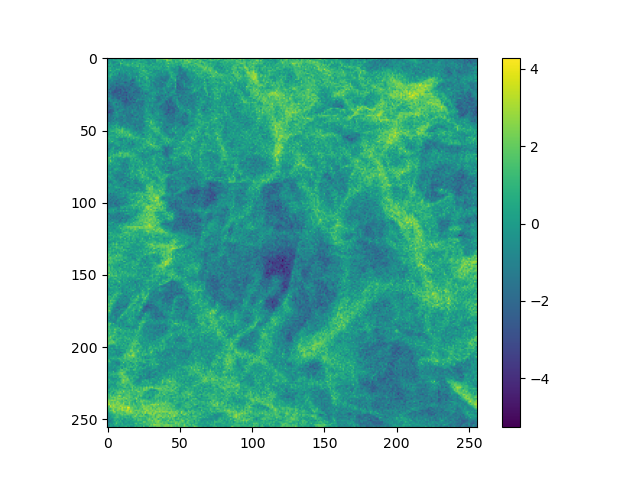

In [11]:
noise_std_ratio = 0.5
d = x + noise_std_ratio*np.std(x)*np.random.randn(np.shape(x)[0], np.shape(x)[1])
plt.figure()
plt.imshow(d)
plt.colorbar()

Then we need to set some parameters for the WPH. For more details, please check https://github.com/constantauclair/CompSep.

In [12]:
M, N = x.shape # map size
J = int(np.log2(N)-2) # number of scales for the WPH
L = 4 # number of angles between 0 and pi
dn = 0 # number of translations 
pbc = True # periodic boundary conditions

wph_op = pw.WPHOp(M, N, J, L=L, dn=5, device=device) # initialization of the WPH operator
x_coeffs = wph_op.apply(x) # WPH coefficient computation on the clean map x
d_init = np.copy(d) # save of the image d

In the initial component separation algorithm by Constant Auclair, the normalization of the WPH coefficients is a crucial point as it can give different relative importance to different scales. Here we choose to normalize them the same way as in https://github.com/constantauclair/CompSep, by their variance when the set of noise is added :

In [13]:
def compute_std(nb_noise): # compute the normalization of the coefficients
    A = torch.zeros(nb_noise, x_coeffs.shape[0])
    for i in range(nb_noise):
        A[i] = wph_op.apply(x + noise[i], pbc = pbc)
    std = torch.std(A, axis = 0) # variance of the coefficient when different noises are
                                 #added to x
    if device == 0:
        std = std.to('cuda')
    return std

d_coeffs = wph_op.apply(d) # WPH coefficient of d, target of the coefficient separation algorithm

nb_noise = 20 # number of noises in the set
noise = noise_std_ratio*np.std(x)*np.random.randn(nb_noise, np.shape(x)[0], np.shape(x)[1])
loss_graph = [] # to visualize the loss descent, optional
std = compute_std(5) # computation of the normalization

In the algorithm by Constant Auclair, it starts with image $d$ and bends it into $s$. This initial condition will be refered as $s_0$.

In [14]:
# initial image is s0 = d_init = x + n

for i in range(3): # Loop of the epochs
    loss_current = []
    d = d.reshape(M, N)
    coefs_u_bruits = [wph_op.apply(d + n, pbc = pbc) for n in noise]
    biais = 1/nb_noise*sum(coefs_u_bruits) - wph_op.apply(d, pbc = pbc) # bias for Jean-Marc
                                                                #Delouis's (JM) formalism

    # Objective function, computes the loss function
    def objective_JM(y): # Computes the loss and the corresponding gradient
        global eval_cnt
        # Reshape y
        y_curr = y.reshape(M, N)

        # Compute the loss (squared 2-norm)
        loss_tot = torch.zeros(1)
        y_curr, nb_chunks = wph_op.preconfigure(y_curr, requires_grad=True)
        for i in range(nb_chunks):
            y_coeffs_chunk, indices = wph_op.apply(y_curr, i, ret_indices=True, pbc = pbc)
            loss = torch.sum(torch.abs((d_coeffs[indices] - y_coeffs_chunk - biais[indices])
                                       /std[indices]) ** 2)
            loss.backward(retain_graph=True)
            loss_tot += loss.detach().cpu()
            del y_coeffs_chunk, indices, loss

        # Reshape the gradient
        y_grad = y_curr.grad.cpu().numpy().astype(y.dtype)
        loss_current.append(loss_tot.item())
        #print(f"Loss: {loss_tot.item()} (computed in {(time.time() - start_time):.2f}s)")
        eval_cnt += 1
        return loss_tot.item(), y_grad.ravel()

    eval_cnt = 0
    result = opt.minimize(objective_JM, d.ravel(), method='L-BFGS-B', jac=True, tol=None,
                          options={"maxiter": 50, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, d, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    d = d.reshape(M, N)
    loss_graph.append(loss_current)
    print(f"Loss at epoch {i} : {final_loss}")
sep_from_d = np.copy(d)

Loss at epoch 0 : 1026.6689453125
Loss at epoch 1 : 576.575439453125
Loss at epoch 2 : 636.4440307617188


We can now plot this result along with the clean map (x) and the map with noise ($d_{init}$) :

<IPython.core.display.Javascript object>


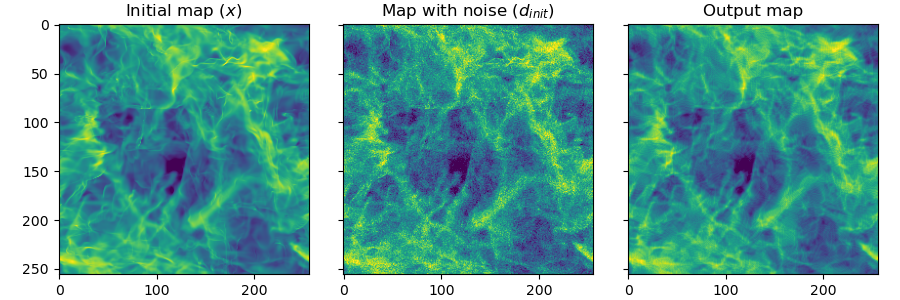

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
vmin=x.mean() - 3*x.std() # color bar limits
vmax=x.mean() + 3*x.std() # color bar limits
axs[0].imshow(x, vmin=vmin, vmax=vmax)
axs[1].imshow(d_init, vmin=vmin, vmax=vmax)
axs[2].imshow(sep_from_d, vmin=vmin, vmax=vmax)
axs[0].set_title('Initial map ($x$)')
axs[1].set_title('Map with noise ($d_{init}$)')
axs[2].set_title('Output map')
fig.tight_layout()

The synthesis looks correct to the naked eye, but we want to check more precisely to what extend it is close to the clean image ($x$).

We can check the power spectra (PS) of theses images :

<IPython.core.display.Javascript object>


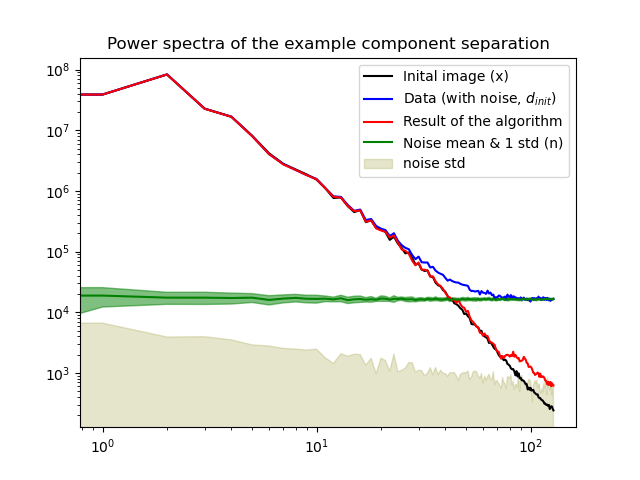

In [19]:
def PS(image): # computation of the (isotropic) power spectrum of an image.
    ampl_TF = np.abs(np.fft.fft2(image))**2
    ampl_TF = np.fft.fftshift(ampl_TF)
    L = np.meshgrid(np.linspace(-N//2+1, N//2, N), np.linspace(-N//2+1, N//2, N))
    T = np.sqrt(L[0]**2 + L[1]**2)
    kbins = np.arange(0, N//2 + 2)
    PS = np.array([np.mean(ampl_TF[np.bitwise_and(kbins[i]<=T, T<kbins[i+1])]) for i
                   in range(N//2+1)])
    return PS

k = np.arange(0, N//2 + 1) # initialisation of the wave vector
plt.figure()

# Computation of the different power spectra
n_PS = np.array([PS(n) for n in noise])

plt.loglog(k, PS(x), label = 'Inital image (x)', color = 'black')
plt.loglog(k, PS(d_init), color = 'blue', label = 'Data (with noise, $d_{init}$)')
plt.loglog(k, PS(d), color = 'red', label = 'Result of the algorithm')

plt.loglog(k, np.mean(n_PS, axis=0), label = 'Noise mean & 1 std (n)', color = 'green')
plt.fill_between(k, np.mean(n_PS, axis=0)- 1*np.std(n_PS, axis=0),
                 np.mean(n_PS, axis=0) + 1*np.std(n_PS, axis=0), color = 'green', alpha = 0.5)
plt.fill_between(k, np.zeros(len(n_PS[0])), np.std(n_PS, axis=0),
                 label = 'noise std', color = 'olive', alpha = 0.2)
plt.title("Power spectra of the example component separation")
plt.legend()

One can notice that for large scales (left side of the graph, small k), the result is really close to x (here in black). But for small scales, the result deviates from the real image x. It occurs when the signal gets close to the standard deviation of the power spectrum of the noise, and the information cannot be recovered.

We can also see that the PS of the result is on top of the one of $x$ for small scales. It comes from the fact that the algorithm starts with the initial map $d_{init}$ and deforms it, which has higher energy in small scales than $x$. As the deformation stops as soon as the statistics are compatible with a realisation of the noise, the PS does not go down to the one of $x$.

We can also check the WPH statistics :

In [20]:
wph_op_plot = pw.WPHOp(N, N, J, L=L, dn=dn, device=device) # New WHP operator for plotting
                                                           #with the choosen coefficients
wph_model = ['S11','S00','S01','Cphase','C00','C01'] # Loading of some of the WPH statistics
wph_op_plot.load_model(wph_model)

def compute_wph(image): # return an array with the selected WPH statistics of an image
    wph = wph_op_plot.apply(image, ret_wph_obj=True, pbc = pbc) # Compute the WPH statistics

    coeffs = []
    coeffs.append(wph.get_coeffs("S11")[0].real)
    coeffs.append(wph.get_coeffs("S01")[0].real)
    coeffs.append(wph.get_coeffs("S01")[0].imag)
    coeffs.append(wph.get_coeffs("C00")[0].real)
    coeffs.append(wph.get_coeffs("C01")[0].real)
    coeffs.append(wph.get_coeffs("Cphase")[0].real)
    return coeffs
    
def plot_wph(coeffs, ax, couleur, legende, log_fig00 = True): #Plot the WPH statistics
                                    #from an array of coefficients (compute_wph output)
    for i in range(3):
        ax[0,i].plot(coeffs[i], color=couleur, label = legende)
    for i in range(3):
        ax[1,i].plot(coeffs[i+3], color=couleur, label = legende)
    
    # Legends and labels
    ax[0,0].set_xlabel('$j_1$')
    ax[0,0].set_title('$S^{11}$')
    
    if log_fig00 == True: # log y-scale for the S11
        ax[0,0].set_yscale('log')
    ax[0,1].set_xlabel('$j_1$')
    ax[0,1].set_title('$\Re(S^{01})$')
    ax[0,2].set_xlabel('$j_1$')
    ax[0,2].set_title('$\Im(S^{01})$')
    ax[1,1].set_xlabel('($j_1$,$j_2$,$\Delta l$)')
    ax[1,1].set_title('$C^{00}$')
    ax[1,2].set_xlabel('($j_1$,$j_2$,$\Delta l$)')
    ax[1,2].set_title('$C^{01}$')
    ax[1,0].set_xlabel('($j_1$,$j_2$)')
    ax[1,0].set_title('$C^{phase}$')
    ax[0,2].legend(loc=3,bbox_to_anchor=(1.05,0.05))

<IPython.core.display.Javascript object>


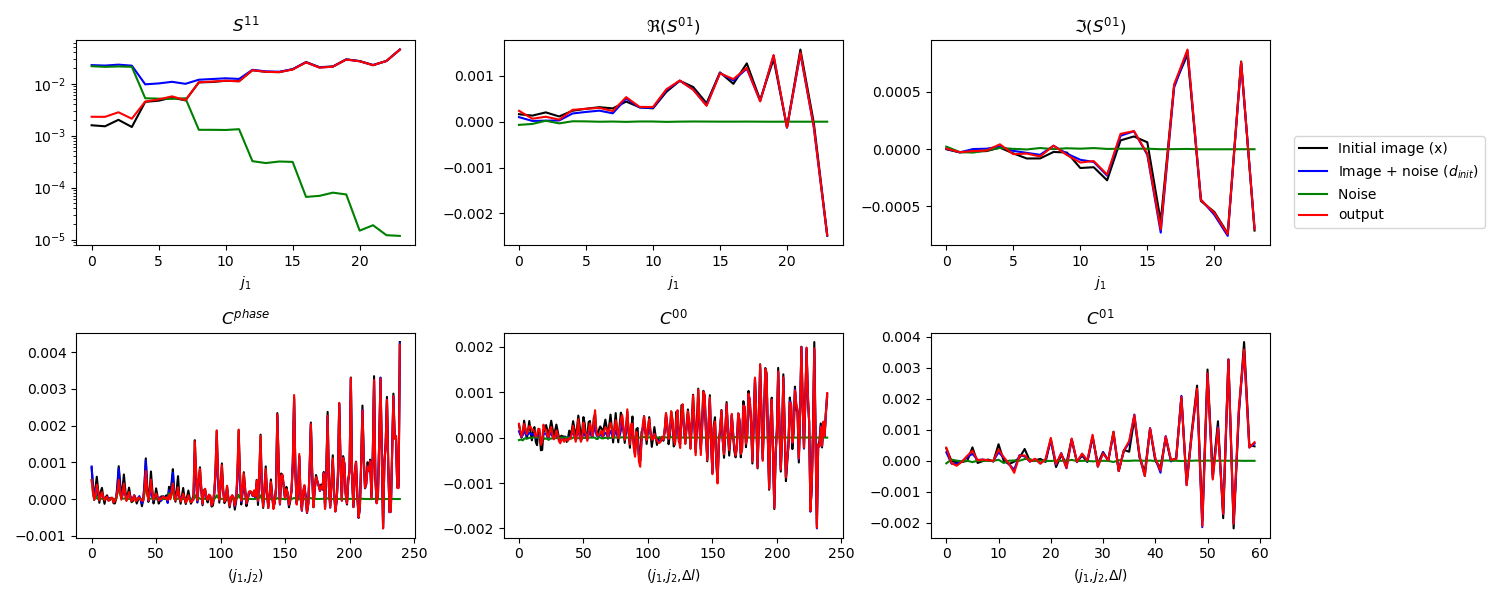

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

plot_wph(compute_wph(x), ax, 'black', 'Initial image (x)')
plot_wph(compute_wph(d_init), ax, 'blue', 'Image + noise ($d_{init}$)')
plot_wph(compute_wph(noise[0]), ax, 'green', 'Noise ')
plot_wph(compute_wph(d), ax, 'red', 'output')

plt.tight_layout()
plt.show()

We can see that the output follows $x$ for most coefficients, and deviates when the noise is preponderent, as seen earlier with the power spectrum. This is particularly apparent for the $S^{11}$.

## 3. Exploration of different outcomes of variations of the algorithm

The component separation algorithm gave a convincing image, but it is imperfect at small scales. 
But we can try to get a clearer idea of what parts of the result are a true reconstruction of the initial one $x$, and what is an artefact of the algorithm. This leads us to consider all the possible clean images that are compatible with the data we have.

We can for instance change the initial image of the algorithm $s_0$ from $d_{init} = x + n$ to a white noise (WN) to have a different result. The initial image is the initial condition of the algorithm, the one it deforms into the result.

In [22]:
# s0 map into d :
d = np.std(d_init) * np.random.randn(np.shape(x)[0], np.shape(x)[1]) # WN, initial
                                                        #image for the algorithm s0

In [23]:
for i in range(5): # Loop of the epochs
    loss_current = []
    d = d.reshape(M, N)
    coefs_u_bruits = [wph_op.apply(d + n, pbc = pbc) for n in noise]
    biais = 1/nb_noise*sum(coefs_u_bruits) - wph_op.apply(d, pbc = pbc) # bias
                                                    #for Jean-Marc Delouis's (JM) formalism

    def objective_JM(y):
        global eval_cnt
        # Reshape y
        y_curr = y.reshape(M, N)

        # Compute the loss (squared 2-norm)
        loss_tot = torch.zeros(1)
        y_curr, nb_chunks = wph_op.preconfigure(y_curr, requires_grad=True)
        for i in range(nb_chunks):
            y_coeffs_chunk, indices = wph_op.apply(y_curr, i, ret_indices=True, pbc = pbc)
            loss = torch.sum(torch.abs((d_coeffs[indices] - y_coeffs_chunk - biais[indices])
                                       /std[indices]) ** 2)
            loss.backward(retain_graph=True)
            loss_tot += loss.detach().cpu()
            del y_coeffs_chunk, indices, loss

        # Reshape the gradient
        y_grad = y_curr.grad.cpu().numpy().astype(y.dtype)
        loss_current.append(loss_tot.item())
        #print(f"Loss: {loss_tot.item()} (computed in {(time.time() - start_time):.2f}s)")
        eval_cnt += 1
        return loss_tot.item(), y_grad.ravel()

    eval_cnt = 0
    result = opt.minimize(objective_JM, d.ravel(), method='L-BFGS-B', jac=True, tol=None,
                          options={"maxiter": 50, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, d, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    d = d.reshape(M, N)
    loss_graph.append(loss_current)
    print(f"Loss at epoch {i} : {final_loss}")
sep_from_WN = np.copy(d)

Loss at epoch 0 : 24456.0390625
Loss at epoch 1 : 5275.6171875
Loss at epoch 2 : 2552.206298828125
Loss at epoch 3 : 1869.6966552734375
Loss at epoch 4 : 1592.5159912109375


<IPython.core.display.Javascript object>


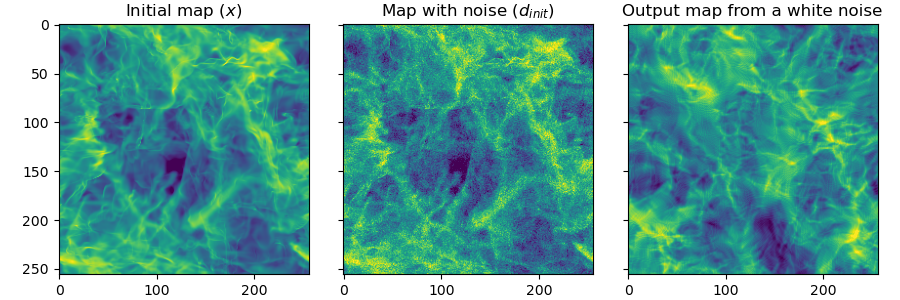

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
vmin=x.mean() - 3*x.std()
vmax=x.mean() + 3*x.std()
axs[0].imshow(x, vmin=vmin, vmax=vmax)
axs[1].imshow(d_init, vmin=vmin, vmax=vmax)
axs[2].imshow(d, vmin=vmin, vmax=vmax)
axs[0].set_title('Initial map ($x$)')
axs[1].set_title('Map with noise ($d_{init}$)')
axs[2].set_title('Output map from a white noise')
fig.tight_layout()

When generated from a white noise, the result is no longer deterministic. The algorithm makes sure the output map has close WPH statistics to the initial one, but the structures are not in the same place. It is not a problem here as the goal is to explore the statistics of the maps and not to compare the maps themselves.

Note that this issue can be solved with a synthesis from $d_{init} = s + n$ to this output.

<IPython.core.display.Javascript object>


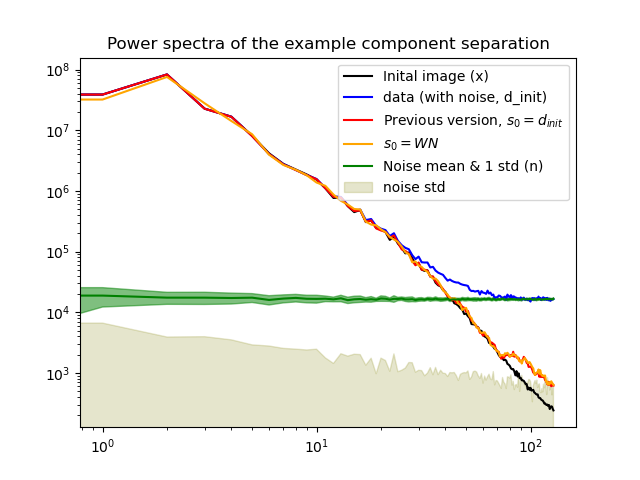

In [25]:
plt.figure()

n_PS = np.array([PS(n) for n in noise])

plt.loglog(k, PS(x), label = 'Inital image (x)', color = 'black')
plt.loglog(k, PS(d_init), color = 'blue', label = 'data (with noise, d_init)')
plt.loglog(k, PS(sep_from_d), color = 'red', label = 'Previous version, $s_0 = d_{init}$')
plt.loglog(k, PS(sep_from_WN), color = 'orange', label = '$s_0 = WN$')

plt.loglog(k, np.mean(n_PS, axis=0), label = 'Noise mean & 1 std (n)', color = 'green')
plt.fill_between(k, np.mean(n_PS, axis=0)- 1*np.std(n_PS, axis=0),
                 np.mean(n_PS, axis=0) + 1*np.std(n_PS, axis=0), color = 'green', alpha = 0.5)
plt.fill_between(k, np.zeros(len(n_PS[0])), np.std(n_PS, axis=0), label = 'noise std',
                 color = 'olive', alpha = 0.2)
plt.title("Power spectra of the example component separation")
plt.legend()

We can notice that the power spectra are also slightly unalike with the two different $s_0$.

### 3.1. Initial condition with a wide range of power spectra

The algorithm needs an initial map $s_0$ to deform it into the denoised map. We have seen that it changes the result when $s_0$ is a white noise (WN). But we can go further and start with a wide variety of initial maps.

The previous algorithm gives a result with a power spectrum (PS) which deviates from $x$ at small scales. This deviation depends on the initial condition $s_0$, so the idea is to start with Gaussian images with different power spectra (PS) to explore the possible outcomes.

To build a range of starting images, we choose to start from the power spectrum of x, and deform it.
Indeed, if the power spectrum is too far from x, the algorithm will not converge. We choose this deformation to become bigger as the noise is preponderant, because it is the part where lots of the variance comes from, and it is therefore useless to deform the PS where the algorithm is correct.

<IPython.core.display.Javascript object>


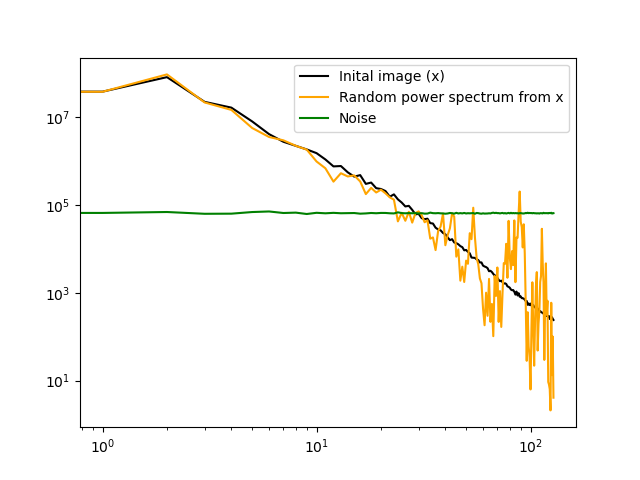

In [29]:
noise_std_ratio = 1 # We choose a higher signal-to-noise ratio to see the effect of
                    #the noise more easily
noise = noise_std_ratio*np.std(x)*np.random.randn(nb_noise, np.shape(x)[0],
                                                  np.shape(x)[1]) # redefining the noise set

def smoothing(L): # smooth a list of len L to a list of len L-2
    return (L[2:] + L[1:-1] + L[:-2])/3

rd = np.random.uniform(-0.999,1,len(PS(x))+2) # random part of the PS
rd = smoothing(rd) # we smooth the PS to help the algoritm converging
rd = rd * (PS(noise[0])/PS(x))**0.3 # deformation where the noise is preponderant
rd_PS = PS(x) *(10**rd) # perturbation from the PS of x

plt.figure()
plt.loglog(k, PS(x), label = 'Inital image (x)', color = 'black')
plt.loglog(k, rd_PS, label = 'Random power spectrum from x', color = 'orange')
plt.loglog(k, np.mean(n_PS, axis=0), label = 'Noise', color = 'green')
plt.legend()

A map with this power spectrum can then be easily created with an inverse Fourier transform.

We can now make many syntheses with these initial conditions, by executing the program 'Comp sep Meth1.py'.
It makes a component separation from 50 random initial maps :

In [30]:
method1 = np.load('Result Meth1.npy') # loading the result of this 1st method

We can plot the power spectra :

<IPython.core.display.Javascript object>


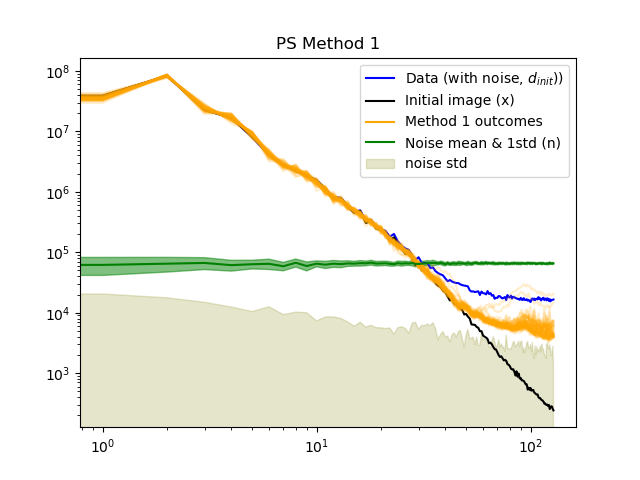

In [35]:
plt.figure()

# Computation of the different PS
n_PS = np.array([PS(n) for n in noise])

plt.loglog(k, PS(d_init), color = 'blue', label = 'Data (with noise, $d_{init}$))')
plt.loglog(k, PS(x), label = 'Initial image (x)', color = 'black')

for d_c in method1: # plot of the range of PS given by the algorithm 'with random initial conditions'
    plt.loglog(k, PS(d_c), color = 'orange', alpha = 0.2)
plt.loglog([], [], color = 'orange', label = 'Method 1 outcomes')

plt.loglog(k, np.mean(n_PS, axis=0), label = 'Noise mean & 1std (n)', color = 'green')
plt.fill_between(k, np.zeros(len(n_PS[0])), np.std(n_PS, axis=0),
                 label = 'noise std', color = 'olive', alpha = 0.2)
plt.fill_between(k, np.mean(n_PS, axis=0)- 1*np.std(n_PS, axis=0),
                 np.mean(n_PS, axis=0) + 1*np.std(n_PS, axis=0), color = 'green', alpha = 0.5)

plt.title('PS Method 1')
plt.legend()

It gives a set of outputs in orange, which follows x for large scales but deviates for smaller ones. All the results are not the same, which shows that changing the initial map makes a true difference in the outcome. This set of results will be studied further along with the second method in the next section.

### 3.2 Double perturbation method

A second way to access a large range of results is to make a first component separation from white noise for example. It gives a first clean map $\tilde s$.
Then, we can add a new noise to this first map: $\tilde d = \tilde s + n$ with $n$ a realisation of the noise, and make a new component separation to denoise $\tilde d$. We also need an initial condition $s_0$, and we will for this method choose a white noise. It gives a second different result.

To obtain several results, we can denoise the set $\tilde d_a = \tilde s + n_a$ for a set of noises $n_a$.

The script 'Comp sep Meth2.py' creates 50 maps with this method ($a$ in range 50)

In [36]:
method2 = np.load('Result Meth2.npy') # loading the results of the 2nd method

<IPython.core.display.Javascript object>


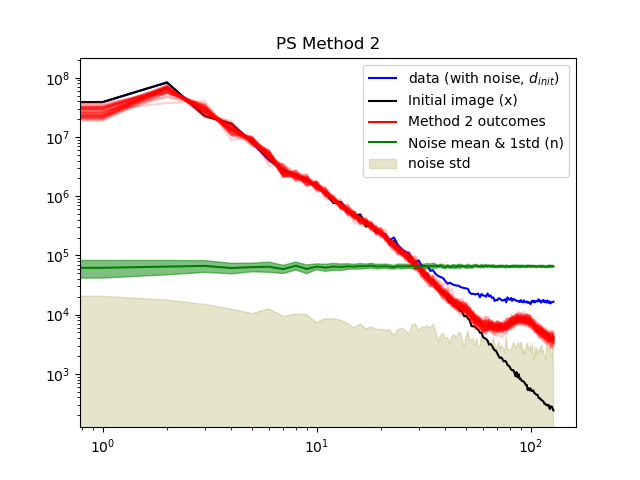

In [37]:
plt.figure()

n_PS = np.array([PS(n) for n in noise])

plt.loglog(k, PS(d_init), color = 'blue', label = 'data (with noise, $d_{init}$)')
plt.loglog(k, PS(x), label = 'Initial image (x)', color = 'black')

for d_c in method2:
    plt.loglog(k, PS(d_c), color = 'red', alpha = 0.2)
plt.loglog([], [], color = 'red', label = 'Method 2 outcomes') # label
    
plt.loglog(k, np.mean(n_PS, axis=0), label = 'Noise mean & 1std (n)', color = 'green')
plt.fill_between(k, np.zeros(len(n_PS[0])), np.std(n_PS, axis=0), label = 'noise std',
                 color = 'olive', alpha = 0.2)
plt.fill_between(k, np.mean(n_PS, axis=0)- 1*np.std(n_PS, axis=0),
                 np.mean(n_PS, axis=0) + 1*np.std(n_PS, axis=0), color = 'green', alpha = 0.5)

plt.title('PS Method 2')
plt.legend()

This results in a new set of images, which we will evaluate in section 4.

### 3.3. A combination of both methods

Another approach can be to combine both methods. We can make component separation from $\tilde d_a = \tilde s + n_a$, but instead of starting from a WN for $s_0$ as for the second method, we can start from an input map with the same random power spectrum as in the first method. It gives a third set of results.

The first step is to generate $\tilde s$ with a first component separation as for the second method.

Then, we can apply a component separation to $\tilde d_a = \tilde s + n_a$, but instead of starting with $s_0$ = WN as for the second method, we can start with $s_0$ being a map generated as in the first method, so a gaussian image with a random power spectrum. It gives a third set of results.

The script 'Comp Sep Method3 gives 50 results with this method.

In [38]:
method_both = np.load('Result Meth3.npy') # loading the results of the 3rd method

<IPython.core.display.Javascript object>


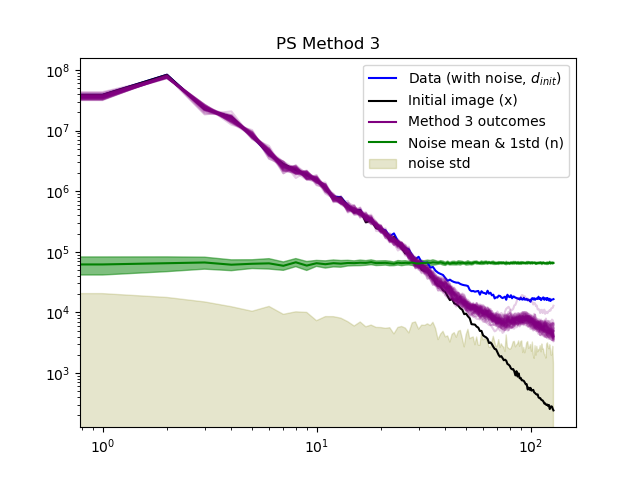

In [39]:
plt.figure()

n_PS = np.array([PS(n) for n in noise])

plt.loglog(k, PS(d_init), color = 'blue', label = 'Data (with noise, $d_{init}$)')
plt.loglog(k, PS(x), label = 'Initial image (x)', color = 'black')

for d_c in method_both:
    plt.loglog(k, PS(d_c), color = 'purple', alpha = 0.2)
plt.loglog([], [], color = 'purple', label = 'Method 3 outcomes') # label

plt.loglog(k, np.mean(n_PS, axis=0), label = 'Noise mean & 1std (n)', color = 'green')
plt.fill_between(k, np.zeros(len(n_PS[0])), np.std(n_PS, axis=0),
                 label = 'noise std', color = 'olive', alpha = 0.2)
plt.fill_between(k, np.mean(n_PS, axis=0)- 1*np.std(n_PS, axis=0),
                 np.mean(n_PS, axis=0) + 1*np.std(n_PS, axis=0), color = 'green', alpha = 0.5)
plt.title('PS Method 3')
plt.legend()

It looks similar to the first and second methods for the power spectra, but it will prove to be different for the WPH statistics.

## 4. Evaluation

We can now evaluate how these methods perform. The power spectra look similar for every method. However, there are more differences in the WPH coefficients. To see it, we can plot the mean coefficient for each method along with its variance, and compare it to $x$ :

We will need a function to print the std of each method :

In [40]:
def error_bar(wph, largeur_std, couleur, alpha, label, axs): # plot the error bars
                                    #from a wph object defined as a global variable
    mean = np.mean(wph.get_coeffs("S11")[0].real, axis = 0) # mean S11 for the set
                                                            #of results
    std = np.std(wph.get_coeffs("S11")[0].real, axis = 0) # variance S11 for the set
                                                          #if results
    axs[0,0].fill_between(np.arange(len(mean)), mean - largeur_std*std ,
                          mean + largeur_std*std, color=couleur, alpha = alpha, label = label)

    mean = np.mean(wph.get_coeffs("S01")[0].real, axis = 0)
    std = np.std(wph.get_coeffs("S01")[0].real, axis = 0)
    axs[0,1].fill_between(np.arange(len(mean)), mean - largeur_std*std ,
                          mean + largeur_std*std, color=couleur, alpha = alpha, label = label)

    mean = np.mean(wph.get_coeffs("S01")[0].imag, axis = 0)
    std = np.std(wph.get_coeffs("S01")[0].imag, axis = 0)
    axs[0,2].fill_between(np.arange(len(mean)), mean - largeur_std*std ,
                          mean + largeur_std*std, color=couleur, alpha = alpha, label = label)

    mean = np.mean(wph.get_coeffs("C00")[0].real, axis = 0)
    std = np.std(wph.get_coeffs("C00")[0].real, axis = 0)
    axs[1,0].fill_between(np.arange(len(mean)), mean - largeur_std*std ,
                          mean + largeur_std*std, color=couleur, alpha = alpha, label = label)

    mean = np.mean(wph.get_coeffs("C01")[0].real, axis = 0)
    std = np.std(wph.get_coeffs("C01")[0].real, axis = 0)
    axs[1,1].fill_between(np.arange(len(mean)), mean - largeur_std*std ,
                          mean + largeur_std*std, color=couleur, alpha = alpha, label = label)

    mean = np.mean(wph.get_coeffs("Cphase")[0].real, axis = 0)
    std = np.std(wph.get_coeffs("Cphase")[0].real, axis = 0)
    axs[1,2].fill_between(np.arange(len(mean)), mean - largeur_std*std ,
                          mean + largeur_std*std, color=couleur, alpha = alpha, label = label)
    
    ax[0,2].legend(loc=3,bbox_to_anchor=(1.05,0.05))

We can now plot the different coefficients for method 1 and 2 :

<IPython.core.display.Javascript object>


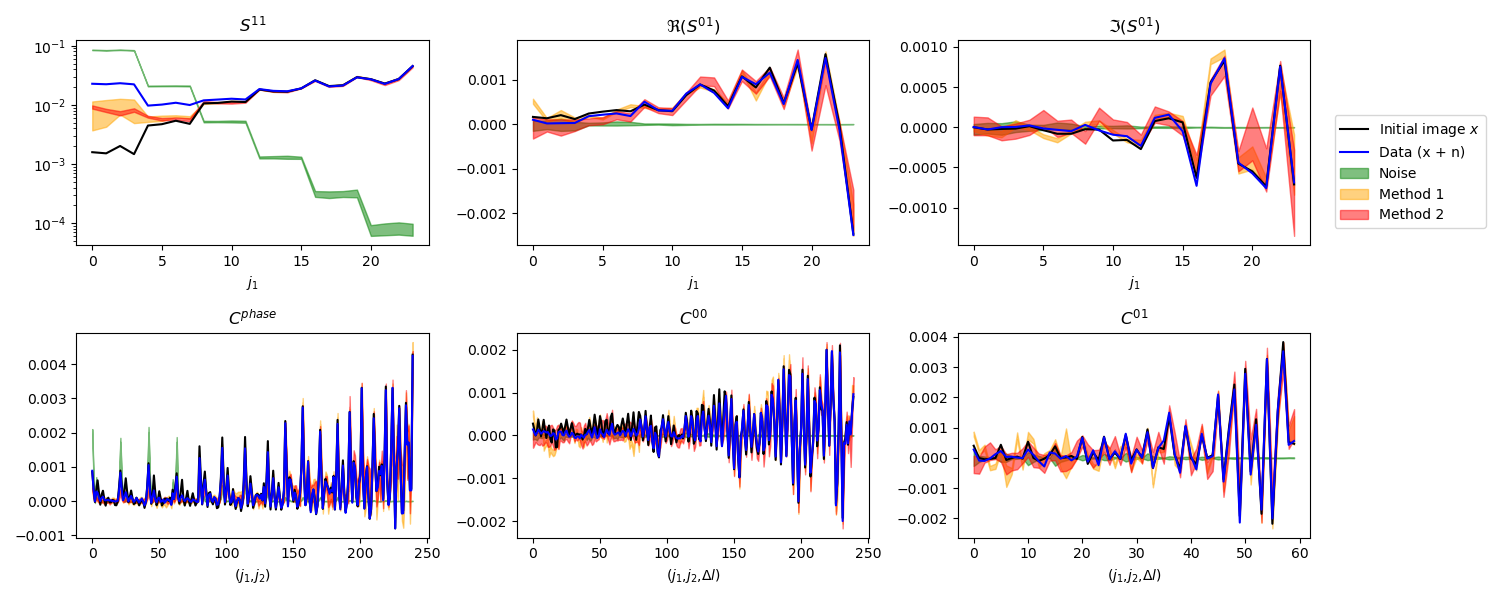

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

plot_wph(compute_wph(x), ax, 'black', 'Initial image $x$') # plot the wph coefficient
                                                           # of the initial image
plot_wph(compute_wph(d_init), ax, 'blue', 'Data (x + n)')

wph = wph_op_plot.apply(noise, ret_wph_obj=True, pbc = pbc)
error_bar(wph, 1, 'green', 0.5, 'Noise', ax) # plot of the error bar with a 1 std thickness

wph = wph_op_plot.apply(method1, ret_wph_obj=True, pbc = pbc)
error_bar(wph, 1, 'orange', 0.5, 'Method 1',ax)

wph = wph_op_plot.apply(method2, ret_wph_obj=True, pbc = pbc)
error_bar(wph, 1, 'red', 0.5, 'Method 2', ax)

plt.tight_layout()
plt.show()

We can see, for the $S^{11}$ for example, that the more intense the noise is, the larger the error bar. It is useful information, as it shows us where there is uncertainty about the outcome of the algorithm.

As there are many coefficients, it is not easy to compare methods 1 and 2. Another possible plot is to print the z-scores. 

Let us write $c(x)$ a WPH coefficient of the map x, and $c(m^i_a)$ the same WPH coefficient of the map $a$ of the set of map generated by method i $m^i$

Then we can compute 
$
\begin{equation} \label{eu_eqn} \large
\frac{|<c(m^i_a)>_a - c(x)|}{\sigma(c(m^i_a))_a}
\end{equation}
$
the z-score of the coefficient c for the method $i$.

In [42]:
def z_score(c_x, c_synt): # compute the z_score for every coefficients of an image
                          #(x) and a set of image (c_synt)
    z_score = []
    for i in range(6):
        c = c_synt[i]
        z_score.append(  np.abs(c_x[i] - np.mean(c, axis =0)) / np.std(c, axis =0)   )
    return z_score

<IPython.core.display.Javascript object>


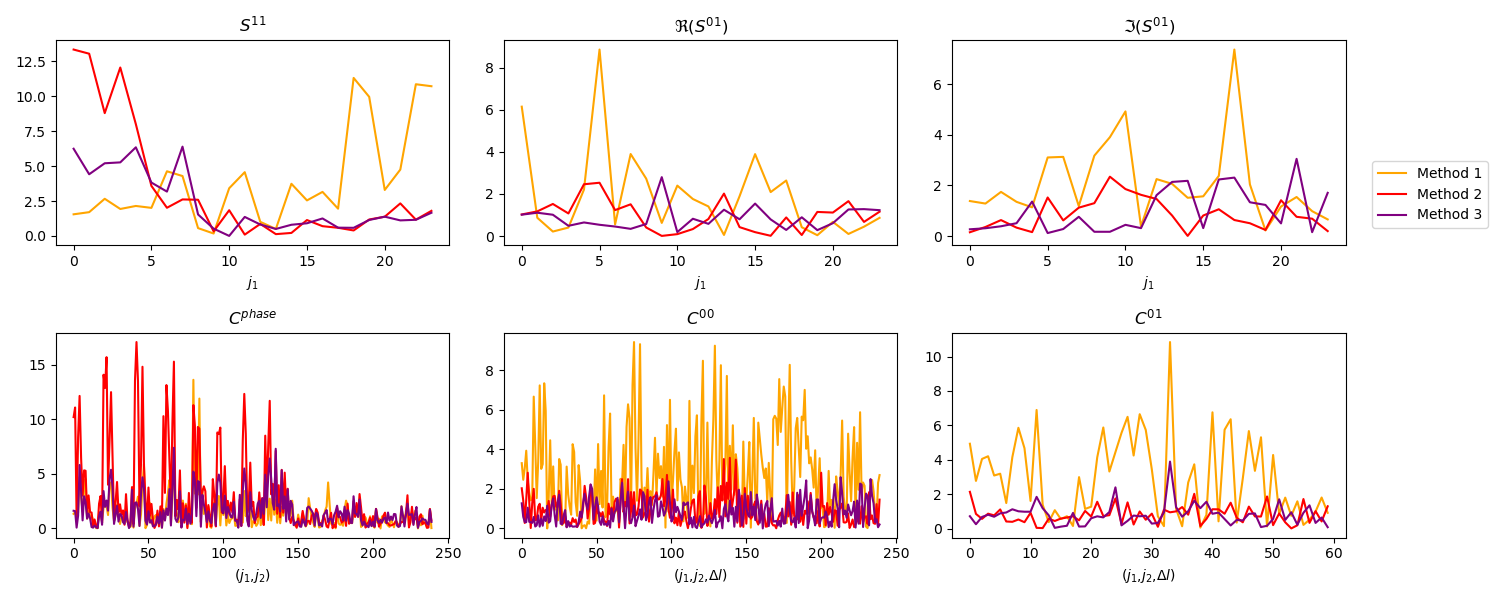

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

plot_wph(z_score(compute_wph(x), compute_wph(method1)), ax, 'orange', 'Method 1',
         log_fig00=False)
plot_wph(z_score(compute_wph(x), compute_wph(method2)), ax, 'red', 'Method 2',
         log_fig00=False)
plot_wph(z_score(compute_wph(x), compute_wph(method_both)), ax, 'purple', 'Method 3',
         log_fig00=False)

plt.tight_layout()
plt.show()

We're aiming for a z_score close to 1. Indeed, the z-score evaluates the ability of the estimator to assess its uncertainty. A higher z-score means that the dispersion of the results is too small, and the method underestimates the uncertainty.

We can see that method 1 (orange) performs well on $C^{phase}$ (lower z-score), while the method 2 (red) one is better for the $S^{01}$ and $C^{01}$.

According to the previous WPH plot, when the method 1 performs well ($C^{phase}$), it is because it follows $x$ more accurately, while the method 2 performs better ($S^{01}$, $C^{01}$) when it has a larger variance and the same accuracy.

On the other hand, method 3 (with both strategies) takes most of the time the best of both methods. It follows the lowest z_score of both methods for a majority of the coefficient.

To have a clearer view of this third method, we can also plot the coefficients themselves :

<IPython.core.display.Javascript object>


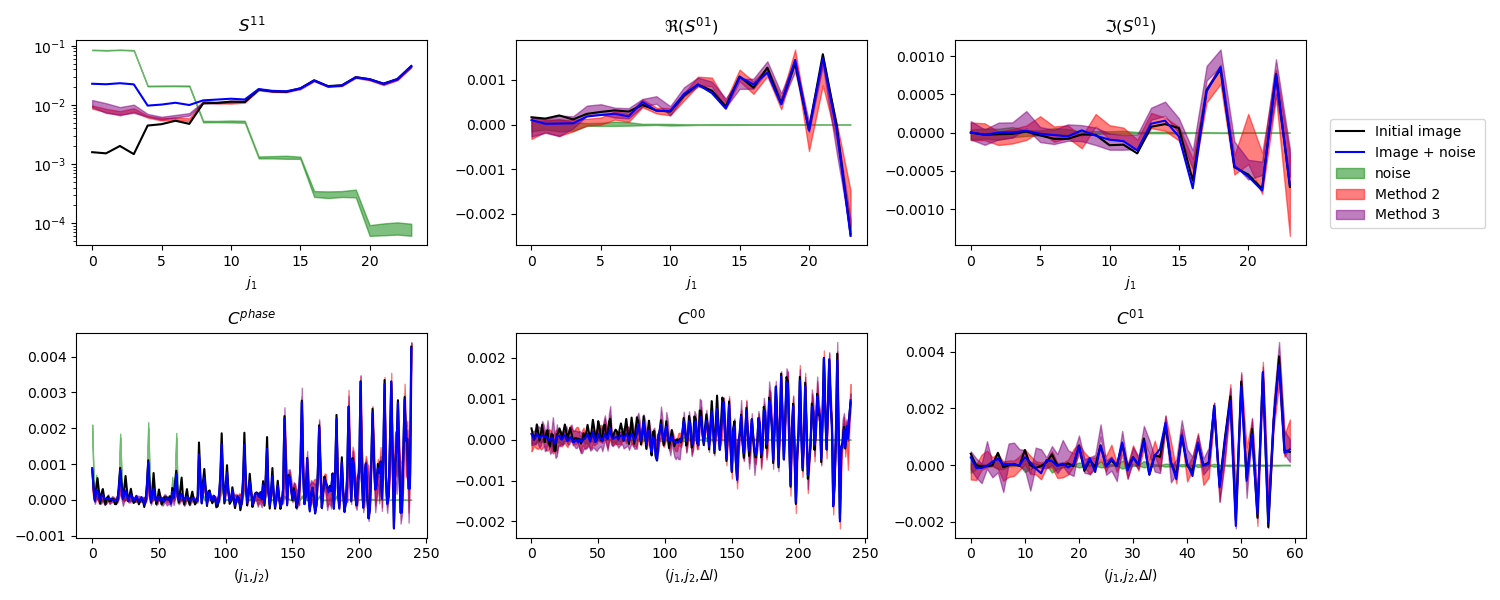

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

plot_wph(compute_wph(x), ax, 'black', 'Initial image') # plot the wph coefficient of
                                                       #the initial image
plot_wph(compute_wph(d_init), ax, 'blue', 'Image + noise ')

wph = wph_op_plot.apply(noise, ret_wph_obj=True, pbc = pbc)
error_bar(wph, 1, 'green', 0.5, 'noise', ax) # plot of the error bar with a 1 std thickness

wph = wph_op_plot.apply(method2, ret_wph_obj=True, pbc = pbc)
error_bar(wph, 1, 'red', 0.5, 'Method 2', ax)

wph = wph_op_plot.apply(method_both, ret_wph_obj=True, pbc = pbc)
error_bar(wph, 1, 'purple', 0.5, 'Method 3', ax)

plt.tight_layout()
plt.show()

Method 3 is on average more precise on the top coefficients ($S^{01}$) and has a larger std ($mean \pm std$ covers the truth $x$ most of the time) for the bottom ones ($C^{phase}$, $C^{00}$, $C^{01}$)

Its z-score is smaller than 2, except for the $S^{01}$ and $C^{phase}$ on small $j$ (it is where the noise is preponderant, cf first figure of section 4) with a z-score close to 5.

We can plot these as histograms by gathering the same type of coefficient together. The next image shows it for 5 more component separation (so with 5 * 50 = 250 component separation).

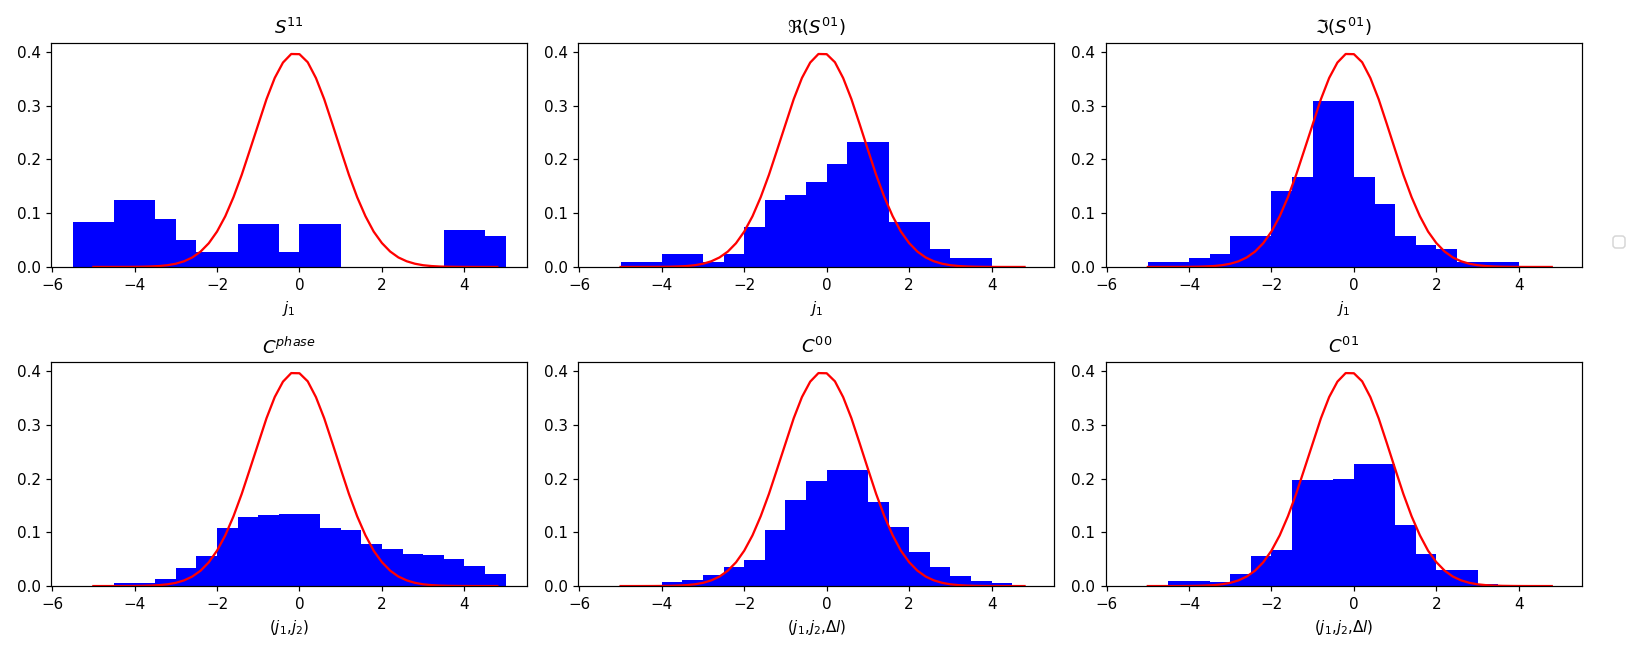

It is shown in superposition with Gaussian with mean & std 1. Note that there is no theoretical reason that it should fit these Gaussians, but it shows the typical extent to which we would expect the repartition if the estimator were unbiased and with a correct estimate of its uncertainties. They are relatively close to 1 or 2, which is a good sign that method 3 was able to demarcate the set of possible clean images.

## 5. Conclusion

We have seen that method 3 was able to find a set of results with a good coverage of the initial image $x$. Its z-score is order 1 for most coefficients.

It enables us to have a more precise idea of what could be hidden by the noise in a component separation. Instead of finding one possible solution which has a part of randomness induced by the initial conditions and the noise set, we can evaluate a set of images compatible with the data. It therefore prevents to be mislead by a random artefact generated by the reconstruction.

We can plot what some of these component separation looks like with method 3.

The clean image and its noised version looks like this :

<IPython.core.display.Javascript object>


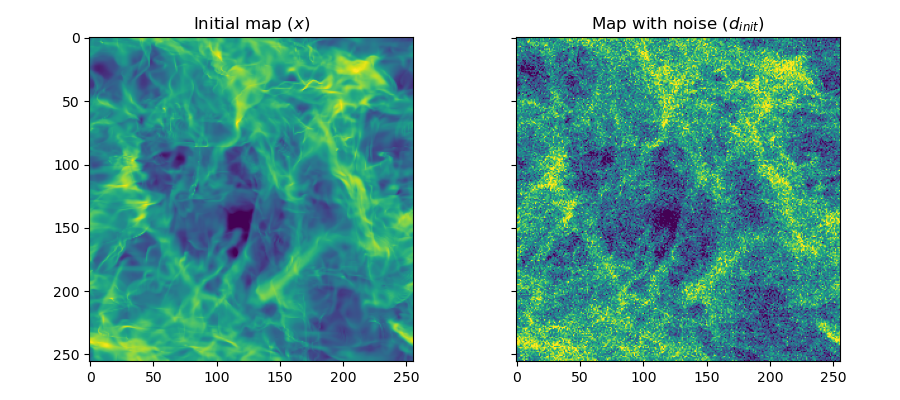

In [45]:
d_noised = x + 1*np.std(x)*np.random.randn(np.shape(x)[0], np.shape(x)[1]) # signal-to-noise = 1

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
vmin=x.mean() - 3*x.std()
vmax=x.mean() + 3*x.std()

axs[0].imshow(x, vmin=vmin, vmax=vmax)
axs[1].imshow(d_noised, vmin=vmin, vmax=vmax)

axs[0].set_title('Initial map ($x$)')
axs[1].set_title('Map with noise ($d_{init}$)')

fig.tight_layout()

To have a clearer view, we also made a last synthesis from $d_{init}$ to the results of method 3 to recover the deterministic part. Here are three result and the initial image $x$:

<IPython.core.display.Javascript object>


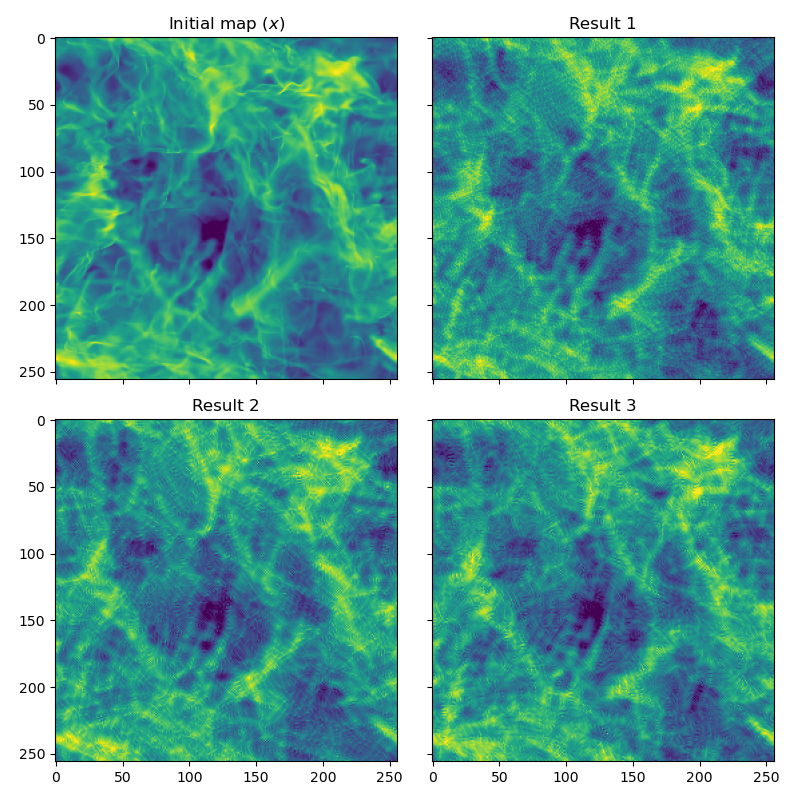

In [46]:
final_images = np.load('Final_image_method3.npy')

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
vmin=x.mean() - 3*x.std()
vmax=x.mean() + 3*x.std()

axs[0,0].imshow(x, vmin=vmin, vmax=vmax)
axs[0,1].imshow(final_images[1], vmin=vmin, vmax=vmax)

axs[1,0].imshow(final_images[3], vmin=vmin, vmax=vmax)
axs[1,1].imshow(final_images[4], vmin=vmin, vmax=vmax)

axs[0,0].set_title('Initial map ($x$)')
axs[0,1].set_title('Result 1')
axs[1,0].set_title('Result 2')
axs[1,1].set_title('Result 3')

fig.tight_layout()

We can also add noise to one of them to compare to the map with noise $d_{init}$:

<IPython.core.display.Javascript object>


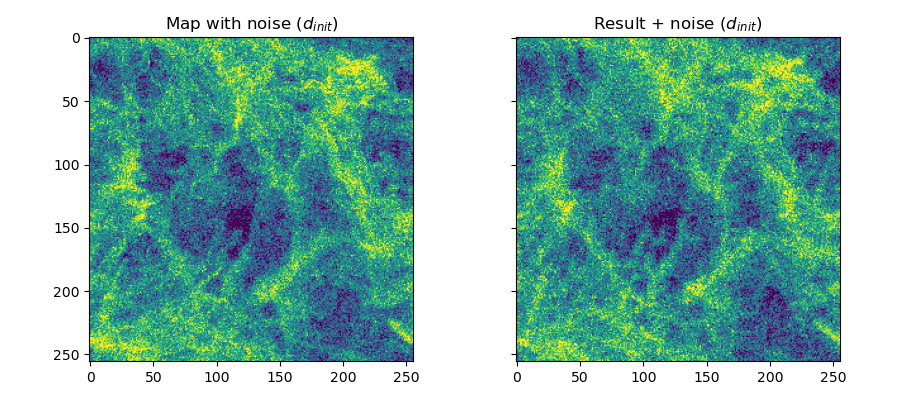

In [47]:
d_noised = x + 1*np.std(x)*np.random.randn(np.shape(x)[0], np.shape(x)[1]) # signal-to-noise = 1
result_noised = final_images[1] + 1*np.std(x)*np.random.randn(np.shape(x)[0], np.shape(x)[1]) 

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
vmin=x.mean() - 3*x.std()
vmax=x.mean() + 3*x.std()

axs[0].imshow(d_noised, vmin=vmin, vmax=vmax)
axs[1].imshow(result_noised, vmin=vmin, vmax=vmax)

axs[0].set_title('Map with noise ($d_{init}$)')
axs[1].set_title('Result + noise ($d_{init}$)')

fig.tight_layout()

These images can explore all the possible textures at small scales as long as they are compatible with the initial image $x$ when noise is added.

They are barely undistinguishable with the noise.

As we haven't used any a priori constraints on the small scales of the process, we end up with textures that seem a bit different from what is expected, mainly at small scales. However, this could be improved in practice by adding constraints on what is expected for the physical process.